In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using DelimitedFiles
using Statistics
using Graphs, GraphRecipes, NetworkLayout

fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [2]:
#Nos busca un indice k tal que los numeros posteriores son 0
#k=3 si |2,1,0,0,0> 
function search_k(M::Int64,n::Vector{Int64})
    k=1 #iniciamos en la pos 1
    for i=1:M #Recorreremos todas las posisiciones M para checar las j>i
        k=i #Nuestro primer prospecto a ser j
        flag=0 #Definimos una bandera si es
                # 1--> significa que encontro una n_{j} tal que los de adelante son 0
                #0--> no lo ha encontrado
        for j=k+1:M-1 #Revisaremos los n_{j} j>i si son cero
            if n[j]!=0 # si encientra una n_{j}!=0
                break  # ya no revises más
            elseif (j == M-1) # si j llega al penultimo valor entonces
                flag=1 # ya lo encontró
            end
        end
        if flag==1 # si la bandera es 1, ya encontro la k
            k=i # entonces esa i es la k
            break # ya no hace falta revisar más
        end
    
    if k==M # si no encontro ningun valor entonces signfica que tomaremos el penultimo valor
        k=M-1
    end
        
    end
    
    return k
end

function base_fock(N::Int64,M::Int64)
    D=binomial(N+M-1,N) #declaramos la variable de la dimension del espacio de Hilbert
    DM=zeros(Int64,(D,M)) #Aquí se colocaran las bases
    n=zeros(Int64,M) #Este vector va a ser el que modificaremos y usaremos para sobre escribir cada fila de DM
    
    DM[1,1]=N #El primer estado de la base
    n[1]=N    # Coincidde con el estado base
    
    l=1 # es un contador para colocar los demas estados
     #k es el indice donde despues de ese todos son ceros
    
    while n[M]!=N
        l+=1 #incrementamos el contador
        k=search_k(M,n) #buscamos la k
        n[k]=n[k]-1 #Primer paso del cambio n_{k}=n_{k}-1
        #Compienza el segundo paso de la suma n_{k+1}=n_{k}-1
        n[k+1]=N

        for i=1:k
            n[k+1]=n[k+1]-n[i]
        end
        #Cambiamos por ceros los n_{i} tales que i>=k+2
        for i=k+2:M
            n[i]=0
        end
        #Agregamos el estado n a la fila l
        DM[l,:]=n
    end
    
    
    return DM;
    
end

# Operadores de Hamiltoniano
function ascenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    part=vector_base[mu]+1
    norm=sqrt(vector_base[mu]+1)
    if part>N
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function descenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    
    part=vector_base[mu]-1
    if vector_base[mu]<0
        norm=0.0
    else
        norm=sqrt(vector_base[mu])
    end
    
    if part<0
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function Numero_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    return vector_base[mu];
end

##//Funcion para localizar vectores base//////////
function Buscador(vector_base::Vector{Int64},N::Int64,M::Int64)

    i0=N #indice para ayudarnos a que este fijo el num de particulas disponibles
    i1=0 #indice para ayudarnos a restar
    Sitios=2 #Numero de sitios que se quitan +1 (al principio se quita un sitio por eso es 2)

    contador=1

    for j=1:M
        while i0-i1 != vector_base[j]
            contador=contador+binomial(M-Sitios+i1,i1)
            i1+=1
        end
        i0=i1
        i1=0
        Sitios+=1
    end

    return contador
end

# Base extendida
function base_2_ex(N::Int64)
    base_2_extendida=zeros(Int64,((N+1)^2,2))
    l=1
    for i=0:N
        for j=0:N
            base_2_extendida[l,:]=[i,j]
            l=l+1
        end
    end
    return base_2_extendida
end

# base_2_extendida=base_2_ex(N)

function buscador_ext_bas(vector_base_ext::Vector{Int64},N::Int64)
    return ( vector_base_ext[1]*(N+1) )+1 +vector_base_ext[2]
end


buscador_ext_bas (generic function with 1 method)

In [3]:
#Hamiltoniano Cinético at_{i}*a_{j} + at_{j}*a_{i}
function H_J_graph(J::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64},g::SimpleGraph{Int64})
    Edges=Tuple.(edges(g)) #La lista hecha tupla de enlaces de la gráfica
    H=zeros(D,D) # contruimos la matriz con las dimensiones D,D
    #Esta es la parte     at_{i}*a_{j} + at_{j}*a_{i}
    for l=1:D #Usaremos cada elemento de la base
        for mus=1:length(Edges) #Recorreremos cada enlace
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos a cada enlace los operadores de creación y aniquilación
            a=descenso_mu(Edges[mus][1],N,n)
            at=ascenso_mu(Edges[mus][2],N,n)

            if at*a != 0
                col=Buscador(n,N,M); #Busca el vector correspondiente al transformado por a*at
                H[col,l]=H[col,l]-J*at*a
                H[l,col]=H[l,col]-J*at*a
            end
        end
    end
    return H
end



#Esta es la parte     at_{mu}*n_{mu+nu}*a_{m+1} + at_{mu+1}*n_{mu+nu}*a_{m}
function H_K1(K1::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            for nu=0:1 #esto es para el operador de numero n_{mu+nu}
                n=bases[l,:] #Es el vector con el que se trabajara
                #Aplicamos las condiciones de frontera periodicas ANILLO
                if mu==M && nu==1
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(1,N,n)
                    at=ascenso_mu(mu,N,n)
                elseif mu==M && nu==0
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(mu,N,n)
                    at=ascenso_mu(mu,N,n)
                else
                    a=descenso_mu(mu+1,N,n)
                    num=Numero_mu(mu+nu,N,n)
                    at=ascenso_mu(mu,N,n)
                end
                if at*a*num != 0
                    col=Buscador(n,N,M)
                    H[col,l]=H[col,l]-K1*at*a*num
                    H[l,col]=H[l,col]-K1*at*a*num
                end
            end
        end
    end
    return H
end


#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_K2(K2::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                a=a*descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                a=a*descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            end

            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-K2*at*a
                H[l,col]=H[l,col]-K2*at*a
            end
        end
    end
    return H
end

#Esta es la parte  n_{m}(n_{m}-1)
function H_U(U::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    for l=1:D #Usaremos cada elemento de la base
        n=bases[l,:] #Es el vector con el que se trabajara
        for i=1:M
            H[l,l]=H[l,l]+U*0.5*(n[i]*(n[i]-1))
        end
    end
    return H

end


#El hamiltoniano es H = H_J + H_K1 + H_K2 + H_U

H_U (generic function with 1 method)

In [4]:
## Se evoluciona con los eigen valores

U_tempo(t,evals)=exp.(-im*evals*t)

#Hay que hace una función con la condicion incial en E con evolución temporal U(t)
function Edo_evol_E(Vector_0, Evol_temp,D)
    Result=zeros(Complex{Float64},D)
    for i=1:D
        Result[i]=Vector_0[i]*Evol_temp[i]
    end
    return Result
end

function rho_c_reducida_ex(n_nu::Int64,n_mu::Int64,N::Int64,M::Int64,D::Int64,
                                bases::Matrix{Int64},base_2_extendida::Matrix{Int64},rho_c::Matrix{ComplexF64},T=false)
   
    rho_c_reducida_exten=zeros(ComplexF64,((N+1)^2,(N+1)^2))

    ### Revisamos cada uno de los elemtnos de la base extendida |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}|
    for i=1:(N+1)^2
        for j=1:(N+1)^2
            #### Esta es la primera delta de dirac (conservacion de particulas en la traza) --->
            ####  ---> \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }
            if sum(base_2_extendida[i,:])==sum(base_2_extendida[j,:])
                #println(sum(base_2_extendida[i,:]), sum(base_2_extendida[j,:]))
                ### Aqui es la segunda delta de dirac (Conservacion de particulas sin traza) --->
                ### ----->\delta_{n_{1}^{i}+n_{2}^{i}+...+n_{M}^{i}} , N}
                for k=1:D #Tecnicamente ya sabemos quienes cumplen eso son los de la base de fock
                    # Reviamos que elementos de la base de fock tienen n_{\nu}^{i} y n_{\mu}^{i} simultaneamente de la base extendida para i
                    # el k-esimo elemento es <k|\rho(t)| NOSE >
                    if bases[k,:][n_nu]==base_2_extendida[i,1] && bases[k,:][n_mu]== base_2_extendida[i,2] 
                        #println(i," ",j," ",base_2_extendida[i,:], " ", base_2_extendida[j,:])
                        #falta construir el NOSE que se compone de |n_{}^{i}...n_{\nu}^{j}...n_{\mu}^{j}>
                        #Con el <k| coinciden los que no son n_{\nu}^{j} n_{\mu}^{j}, entonces
                        NOSE=bases[k,:]
                        NOSE[n_nu],NOSE[n_mu]=base_2_extendida[j,:][1],base_2_extendida[j,:][2]
                        #println(Buscador(bases[k,:],N,M), " ", Buscador(NOSE,N,M))
                        rho_c_reducida_exten[i,j]+=rho_c[Buscador(bases[k,:],N,M),Buscador(NOSE,N,M)]
                        #println("En en la entrada "*L"|",base_2_extendida[i,:],L"\rangle\langle",base_2_extendida[j,:],L"|"*"Entre!")
                    end

                end

            else
                #println(0)
            end

        end
    end
    
    if T==false
        return rho_c_reducida_exten #<----------------------Resultado
    else
        rho_c_reducida_exten_trans_par=zeros(ComplexF64,((N+1)^2,(N+1)^2))
        ## Vamos a recorer cada elemento de la matriz de densidad reducida para transponerla
        for i=1:(N+1)^2
                for j=1:(N+1)^2
                ### Trasnponemos |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}| --->
                ###     ------>  |n_{\nu}^{i},n_{\mu}^{j}><n_{\nu}^{j},n_{\mu}^{i}|
                Transpo1=buscador_ext_bas( [base_2_extendida[i,:][1], base_2_extendida[j,:][2]] ,N)
                Transpo2=buscador_ext_bas( [base_2_extendida[j,:][1], base_2_extendida[i,:][2]] ,N)
                
                rho_c_reducida_exten_trans_par[Transpo1,Transpo2]=rho_c_reducida_exten[i,j]
                #println(i-1,",",j-1,"--->",Transpo1-1,",",Transpo2-1)
            end
        end
        return rho_c_reducida_exten_trans_par#<----------------------Resultado
    end
    
end


rho_c_reducida_ex (generic function with 2 methods)

In [5]:
function Negativity(N::Int64,M::Int64,J::Float64,U::Float64,n_nu::Int64,n_mu::Int64,
    Vector_0_F::Vector{Float64},bases::Matrix{Int64},H::Matrix{Float64},times)
    
    ####################
    D=binomial(N+M-1,N)
    #bases=base_fock(N,M)
    base_2_extendida=base_2_ex(N) #BAses para dos sitios extendida


    
    # Hamiltoniano

    #H=H_J(J,N,M,D,bases)+H_U(U,N,M,D,bases) #+H_K1(J,N,M,D,bases) + H_K2(J,N,M,D,bases)

    Change_E_F=eigvecs(H) # MAtriz cambio de base de Energias a Fock
    Change_F_E=transpose(Change_E_F) # MAtriz cambio de base de Fock a Energias

    # Hay que hacerel cambio de base antes de hacer la evolución temporal
    Vector_0_E=Change_F_E*Vector_0_F

    #Para la evolcución temporal necesitamos los eigenvalores
    evals=eigvals(H)
    #####################33

    ## AQUI EMPIEZA LA DINAMICA## NEGATIVIDAD
    DATA_N=zeros(length(times))
    #How_many=zeros(length(times))
    for (index,t) in enumerate(times)
        Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(t,evals),D) #<--- Aqui evoluciona el tiempo


        #print(t)
        #display(Edo_F_t)
        #HAcemos la matriz de densidad
        rho_c=Edo_F_t*transpose(conj(Edo_F_t))
    #         if index==10
    #             display(Edo_F_t)
    #         end
        Eva=eigvals(rho_c_reducida_ex(n_nu,n_mu,N,M,D,bases,base_2_extendida,rho_c,true))
        Negativity=0
        #MANY=0
        for i in Eva
            if i<0
                #MANY+=1
                Negativity=Negativity+abs(i)
            end
        end
        #How_many[index]=MANY
        DATA_N[index]=Negativity
    end
    return DATA_N
end

Negativity (generic function with 1 method)

In [6]:
function grapho_distances(n,d)
    g = cycle_graph(n)
    for i=1:n
        vert=(i+d)%n;
        vert= vert == 0 ? n : vert;
        add_edge!(g, i, vert)
        #println(i," ",vert)
    end
    return g
end
#graphplot(g, curves=false,method=:circular)


grapho_distances (generic function with 1 method)

In [7]:
M=4

4

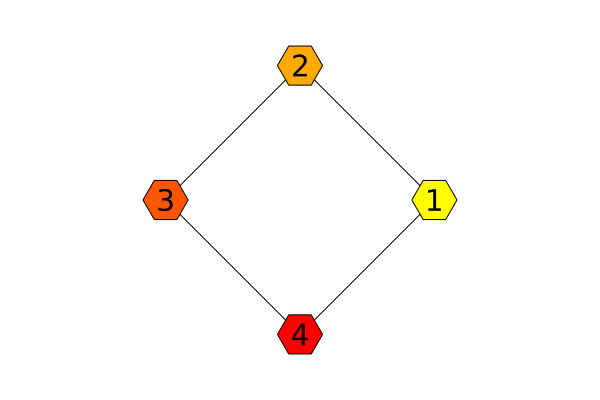

In [8]:
g=grapho_distances(M,1)
graphplot(g, curves=false,method=:circular,names=1:M,fontsize=20,
        nodecolor=range(colorant"yellow", stop=colorant"red", length=M))


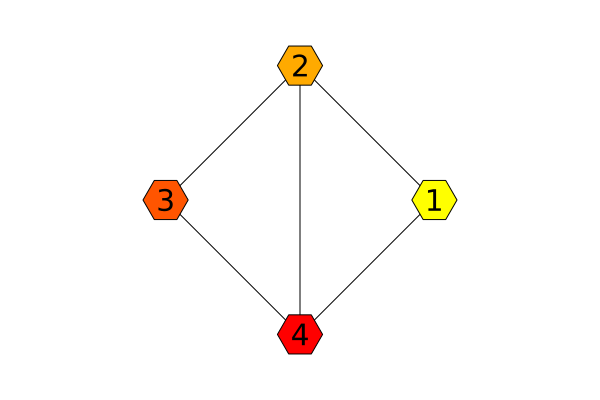

In [9]:
g = cycle_graph(M)
add_edge!(g, 2, 4)
#add_edge!(g, 1, 3)
graphplot(g, curves=false,method=:circular,names=1:M,fontsize=20,
        nodecolor=range(colorant"yellow", stop=colorant"red", length=M))


In [10]:
N=5
#M=4
D=binomial(N+M-1,N)
bases=base_fock(N,M)
bases;

In [11]:
J=1.0e0
K1=0.0
K2=0.0
U=1.0*0

# tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
n_nu=1
n_mu=3

# tiempo
dt=0.01
Time_0=0
Time_f=100
times=Time_0:dt:Time_f

# Condicion inicial, puede ser localizada
Vector_0_F=zeros(D) 
Vector_0_F[Buscador([N,0,0,0],N,M)]=1

#Hamiltoniano
H=H_J_graph(J,N,M,D,bases,g)+H_U(U,N,M,D,bases); #+H_K1(J,N,M,D,bases) + H_K2(J,N,M,D,bases)

In [12]:
@time Data_N=Negativity(N,M,J,U,n_nu,n_mu,Vector_0_F,bases,H,times);

 20.192567 seconds (209.59 M allocations: 18.633 GiB, 7.68% gc time, 19.51% compilation time)


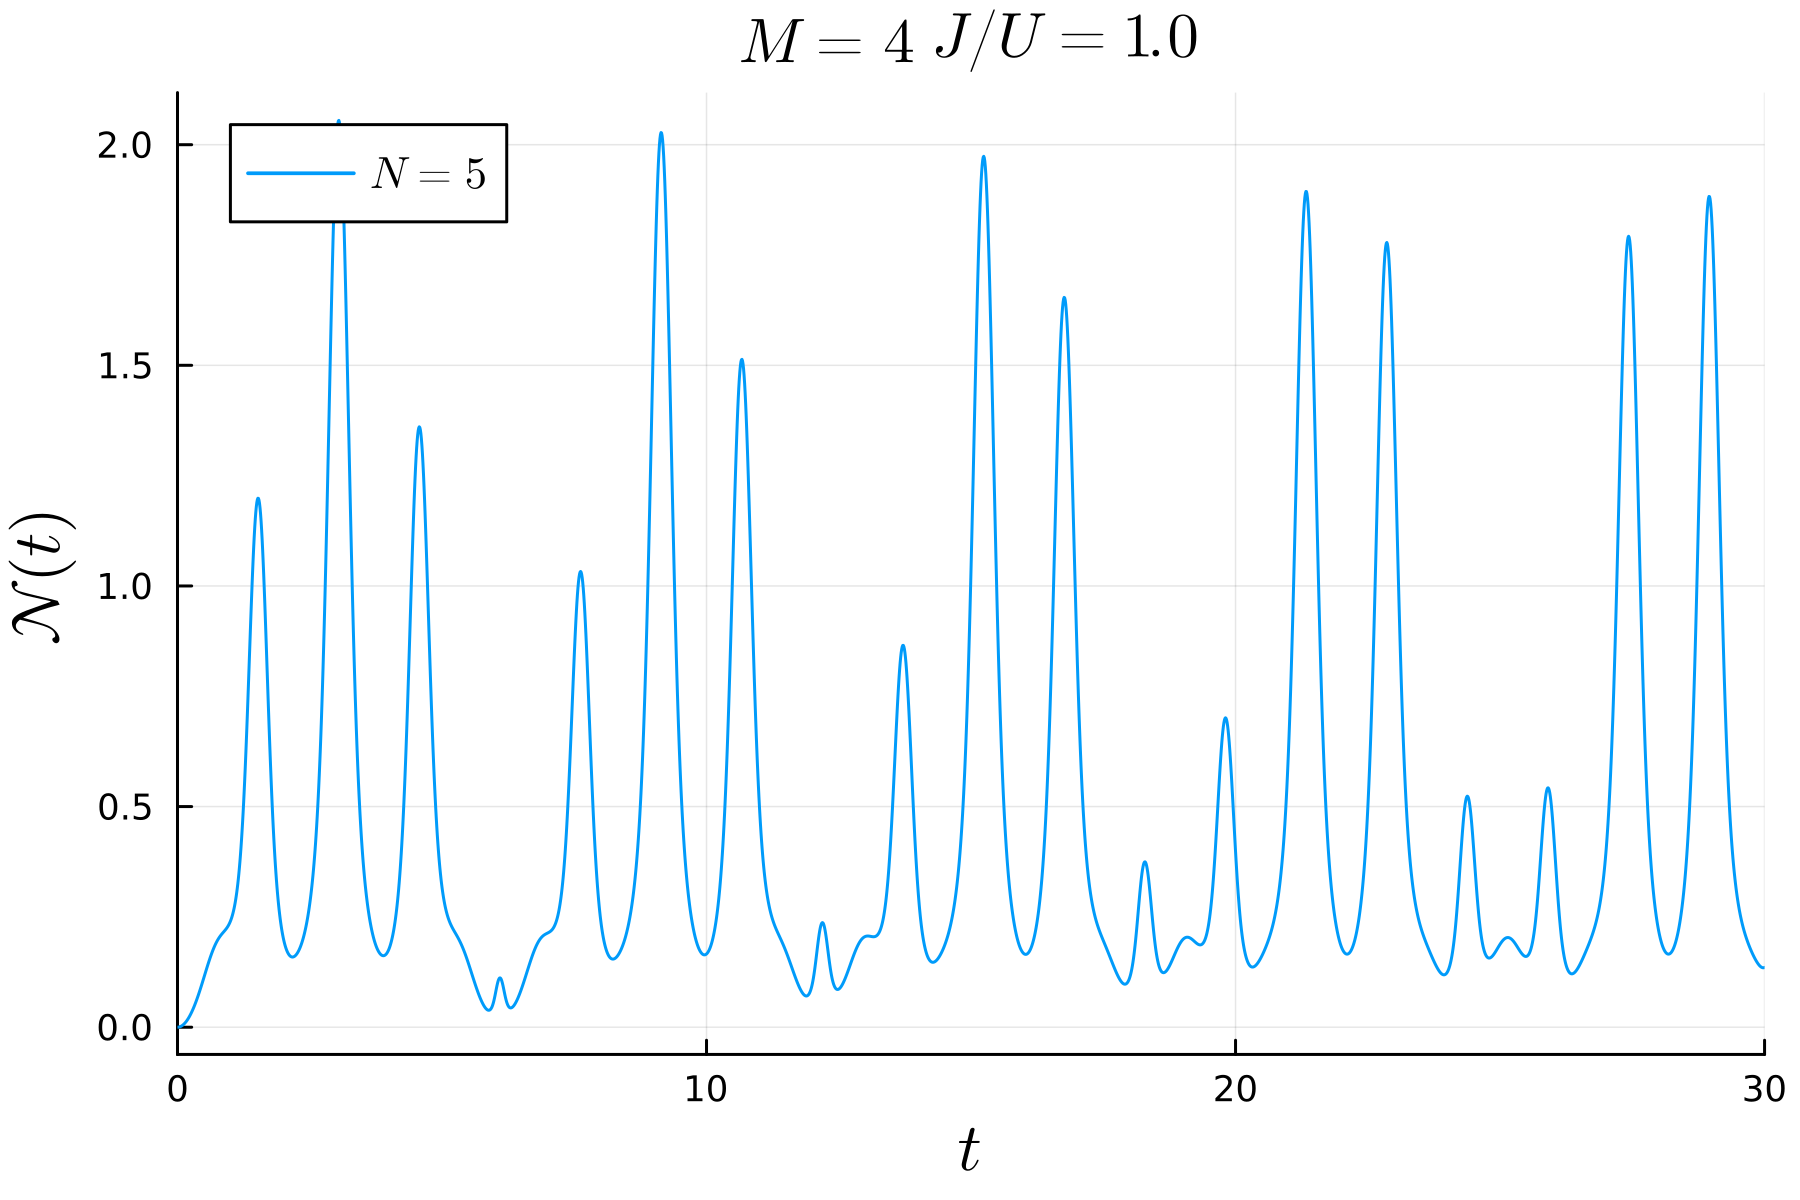

In [19]:

plot(times,Data_N,guidefont=fnt, fmt = :png, dpi=300.,
    title=L" M=%$M"*" "*L"J/U=%$J",#L", M="*latexstring(M)*L", N="*latexstring(N)*L", \nu="*latexstring(n_nu)*L", \mu="*latexstring(n_mu),
    label=L"N=%$N",
    ylabel=L"\mathcal{N}(t)",xlabel=L"t",
    linestyle=:solid,lw=1,legend=:best,legendfontsize=10,
    xlims=(0,30))

# Minado de datos


In [14]:
#Primero la forma de la red
#Segundo los sitios de interes

#Numero de bosones
#Condiciones iniciales
#J/U


In [15]:
#PENSANDO ANILLO CON ATAJOS

#Crea el nombre de la carpeta: 
#./NOMBRE/CASO_N_M/Contiguos-No contiguos/

function nombre_carpeta(N::Int64,M::Int64,n_nu::Int64,n_mu::Int64,Name)
    ####Creamos el directorio
    name_dir1="./$(Name)/Caso_N$(N)_M$(M)"
    name_dir2=""
    if abs(n_nu-n_mu)==1
        name_dir2="/Contiguos/"
    else
        name_dir2="/No_Contiguos_$(n_nu+1-n_mu)/" #solo puedes seleccionar de M es par... n_mu=2,3,4...M/2 + 1
                                                 #solo puedes seleccionar de M es impar... n_mu=2,3,4...M-1/2 + 1
    end
    return directorio=name_dir1*name_dir2
end

# Crea la dirección del archivo
#./NOMBRE/CASO_N_M/Contiguos-No contiguos/(#Config inicial#)_nm_nn_(U/J)_fin.dat

function nombre_archivo(U::Float64,num_base::Int64,N::Int64,M::Int64,n_nu::Int64,n_mu::Int64,Name,T=true) 
    name1=""
    for j=1:M
        name1=name1*string(bases[num_base,j])
    end
    directorio=nombre_carpeta(N,M,n_nu,n_mu,Name)
    return archivo=directorio*name1*"_nm$(n_mu)_nn$(n_nu)__U$(U)_fin.dat"
end


nombre_archivo (generic function with 2 methods)

## Red de 4 sitios y un atajo

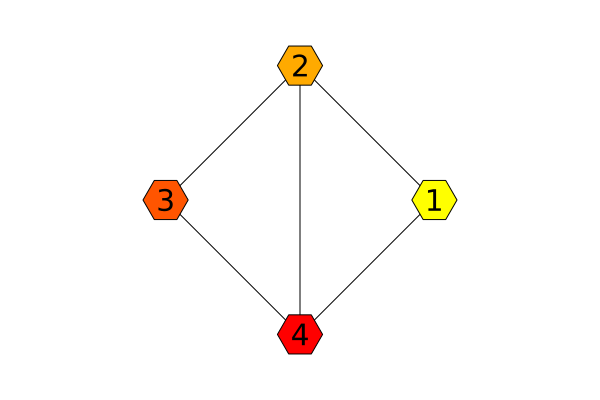

In [16]:
M=4
g=grapho_distances(M,1)
add_edge!(g, 2, 4)
#add_edge!(g, 1, 3)
graphplot(g, curves=false,method=:circular,names=1:M,fontsize=20,
        nodecolor=range(colorant"yellow", stop=colorant"red", length=M))

In [17]:
# tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
n_nu=1
n_mu=2

Ns=[1,2,3,4,5]
Js=1.0
Us=[1.0, 0.01,0.05,0.1,0.25,0.5,1.0,2.5,5.0,10.0]

# tiempo
dt=0.01
Time_0=0
Time_f=100
times=Time_0:dt:Time_f

D=0
N=0
U=0

Name="Negativities_Red_M$(M)_g24"

for i_n=1:length(Ns)
    for i_u=1:length(Us)

        N=Ns[i_n]
        N==1 ? U=0.0 : U=Us[i_u]

        D=binomial(N+M-1,N)
        bases=base_fock(N,M)

        #Hamiltoniano
        H=H_J_graph(J,N,M,D,bases,g)+H_U(U,N,M,D,bases);

        for i_mu=1:M
            for i_nu=1:M
        # tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
                i_mu==i_nu ? continue : nothing 
                    
                n_nu=i_nu
                n_mu=i_mu
                for i_bas=1:D
                    # Condicion inicial, puede ser localizada
                    num_base=i_bas
                    Vector_0_F=zeros(D) 
                    Vector_0_F[num_base]=1


                    ## Lo escribimos en un archivo
                        
                    directorio=nombre_carpeta(N,M,n_nu,n_mu,Name)
                    mkpath(directorio) #Crea el directroio
                    archivo=nombre_archivo(U,num_base,N,M,n_nu,n_mu,Name)
                    isfile(archivo)==true ? continue : nothing

                    t1=time()
                    Data_N=Negativity(N,M,J,U,n_nu,n_mu,Vector_0_F,bases,H,times);
                    t2=time()
                    current_time=t2-t1


                    f = open(archivo, "w")
                    for i=1:length(times)
                        println(f, times[i], " ", Data_N[i])
                        flush(f) #vacia datos temporales
                    end

                    IJulia.clear_output(true)
                    println("N=$N Caso $(i_n) de $(length(Ns)) \nU/J=$U Caso $(i_u) de $(length(Us)) \nSitio=$(i_mu)/$(M) \nNo_Base=$(i_bas)/$D \nTiempo=$(t2-t1)" )
                end
            end
        end
    end
end
println("TERMINEEEEEEE")


TERMINEEEEEEE


In [20]:
range(colorant"yellow", stop=colorant"red", length=100)
typeof(range(colorant"yellow", stop=colorant"red", length=100))
colorant"cyan"

# Ploteador de Datos

## Para la red de 4 con todas las conexiones

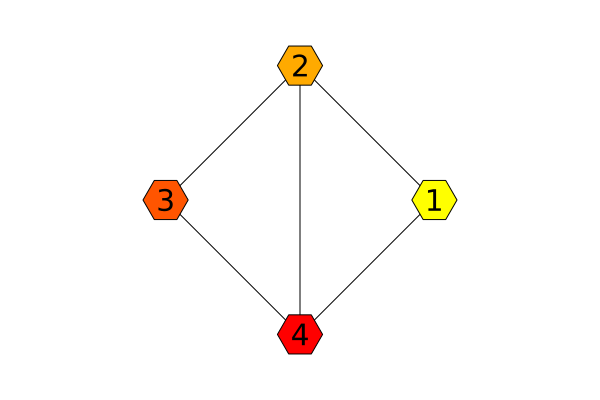

In [21]:
M=4
g=grapho_distances(M,1)
add_edge!(g, 2, 4)
#add_edge!(g, 1, 3)
graphplot(g, curves=false,method=:circular,names=1:M,fontsize=20,
        nodecolor=range(colorant"yellow", stop=colorant"red", length=M))


In [23]:
# Para la red 1
#N=2
J=1.0 #[1.0, 0.01,0.05]
U=1.0
M=4
### Condicion inicial, sitios de interes, la red que lo conforma 
CASOS=[
        [[1,0,0,0],[1,2],"Negativities_Red_M$(M)_g24"],
        [[1,0,0,0],[1,3],"Negativities_Red_M$(M)_g24"],
        [[1,0,0,0],[1,4],"Negativities_Red_M$(M)_g24"]
        ]

3-element Vector{Vector{Any}}:
 [[1, 0, 0, 0], [1, 2], "Negativities_Red_M4_g24"]
 [[1, 0, 0, 0], [1, 3], "Negativities_Red_M4_g24"]
 [[1, 0, 0, 0], [1, 4], "Negativities_Red_M4_g24"]

3-element Vector{String}:
 #undef
 #undef
 #undef

In [30]:
N=0
bases=0
num_base=0
n_mu=0
n_nu=0

direcciones=Vector{String}(undef,length(CASOS))
for i=1:length(CASOS)
    N=sum(CASOS[i][1])
    N==1 ? U=0.0 : nothing

    bases=base_fock(N,M)
    num_base=Buscador(CASOS[i][1],N,M)
    n_nu=CASOS[i][2][1]
    n_mu=CASOS[i][2][2]
    archivo=nombre_archivo(U,num_base,N,M,n_nu,n_mu,Name)
    #println(isfile(archivo))
    direcciones[i]=archivo
end

NAMES_stylo=Vector{String}(undef,length(CASOS))
for i=1:length(CASOS)
    name=""
    for j=1:length(CASOS[i][1])
        if j==CASOS[i][2][1] || j==CASOS[i][2][2]
            name=name*L"\mathbf{%$((CASOS[i][1])[j])}"
        else
            name=name*L"%$((CASOS[i][1])[j])"
        end
    end
    NAMES_stylo[i]=name
end

In [88]:
if U == 0 || Ni==1 
    titlep=L"U/J=0"
    xlab=L"t'[Jt/\hbar]"
else
    titlep=L"U/J=%$(U)"
    xlab=L"t'[Jt/\hbar]"
end

plot(uidefont=fnt,fmt = :png, dpi=700.,
    ylabel=L"\mathcal{N}(t')",xlabel=xlab,title=titlep,
    legend=:best,legendfontsize=10,
    xlims=(0,10),tickfontsize=12,
    guidefontsize=18)
    #size = (500, 500))
for i=1:length(CASOS)
    DATA_N=readdlm(direcciones[i])
    #plot!(DATA_N[:,1],DATA_N[:,2],label=L"\psi(0)=|"*NAMES_stylo[i]*L"\rangle",lw=1.0+(i-1)*(2.15))
    if i==-1
         plot!(DATA_N[:,1],DATA_N[:,2],label=L"\psi(0)=|"*NAMES_stylo[i]*L"\rangle",lw=1.0+(i-1)*(1.15),linestyle=:dash)
    else
        plot!(DATA_N[:,1],DATA_N[:,2],label=L"\psi(0)=|"*NAMES_stylo[i]*L"\rangle",lw=1.0+(i-1)*(0.1))
    end
end
plot!()

LoadError: ArgumentError: Cannot open './Negativities_Red_M4_g24/Caso_N1_M4/Contiguos/1000_nm2_nn1__U0.0_fin.dat': not a file

In [27]:
Js=[1.0, 0.01,0.05,0.1,0.25]
CASOS_4=[[2,0,0,0],[1,2],"Red1"]

name1=""
name2=""
for j=1:length(CASOS_4[1])
    name1=name1*string(CASOS_4[1][j])
    if j==CASOS_4[2][1] || j==CASOS_4[2][2]
        name2=name2*L"\mathbf{%$(CASOS_4[1][j])}"
    else
        name2=name2*L"%$(CASOS_4[1][j])"
    end
end


In [28]:
direcciones=Vector{String}(undef,length(Js))


N0=sum(CASOS_4[1])
M0=length(CASOS_4[1])
nu0=CASOS_4[2][1]
mu0=CASOS_4[2][2]
num_base_0=Buscador(CASOS_4[1],N0,M0)
Name_0="Negativities_$(CASOS_4[3])_M$(M0)"

for i=1:length(Js)
    if i==1 && Js[i]==1.0
        direccion=nombre_archivo(Js[i],num_base_0,N0,M0,nu0,mu0,Name_0,false)
    else
        direccion=nombre_archivo(Js[i],num_base_0,N0,M0,nu0,mu0,Name_0)
    end
    #println(direccion)
    isfile(direccion)==true ? nothing : break
    println(direccion)
    direcciones[i]=direccion
end
direcciones

# for i=1:length(Js)
#     nu=CASOS_4[i][2][1]
#     mu=CASOS_4[i][2][2]
#     Mi=length(CASOS_4[i][1])
#     Ni=sum(CASOS_4[i][1])
#     num_base_i=Buscador(CASOS_4[i][1],Ni,Mi)
#     Name_i="Negativities_$(CASOS_4[i][3])_M$(Mi)"
#     if U == 0 || Ni==1
#         direccion=nombre_archivo(J,num_base_i,Ni,Mi,nu,mu,Name_i,false)
#     else
#         direccion=nombre_archivo(J,num_base_i,Ni,Mi,nu,mu,Name_i)
#     end
#     isfile(direccion)==true ? nothing : break
#     println(direccion)
#     direcciones[i]=direccion
# end

./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__U0_fin.dat
./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.01_fin.dat
./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.05_fin.dat
./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.1_fin.dat
./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.25_fin.dat


5-element Vector{String}:
 "./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__U0_fin.dat"
 "./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.01_fin.dat"
 "./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.05_fin.dat"
 "./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.1_fin.dat"
 "./Negativities_Red1_M4/Caso_N2_M4/Contiguos/2000_nm2_nn1__J0.25_fin.dat"

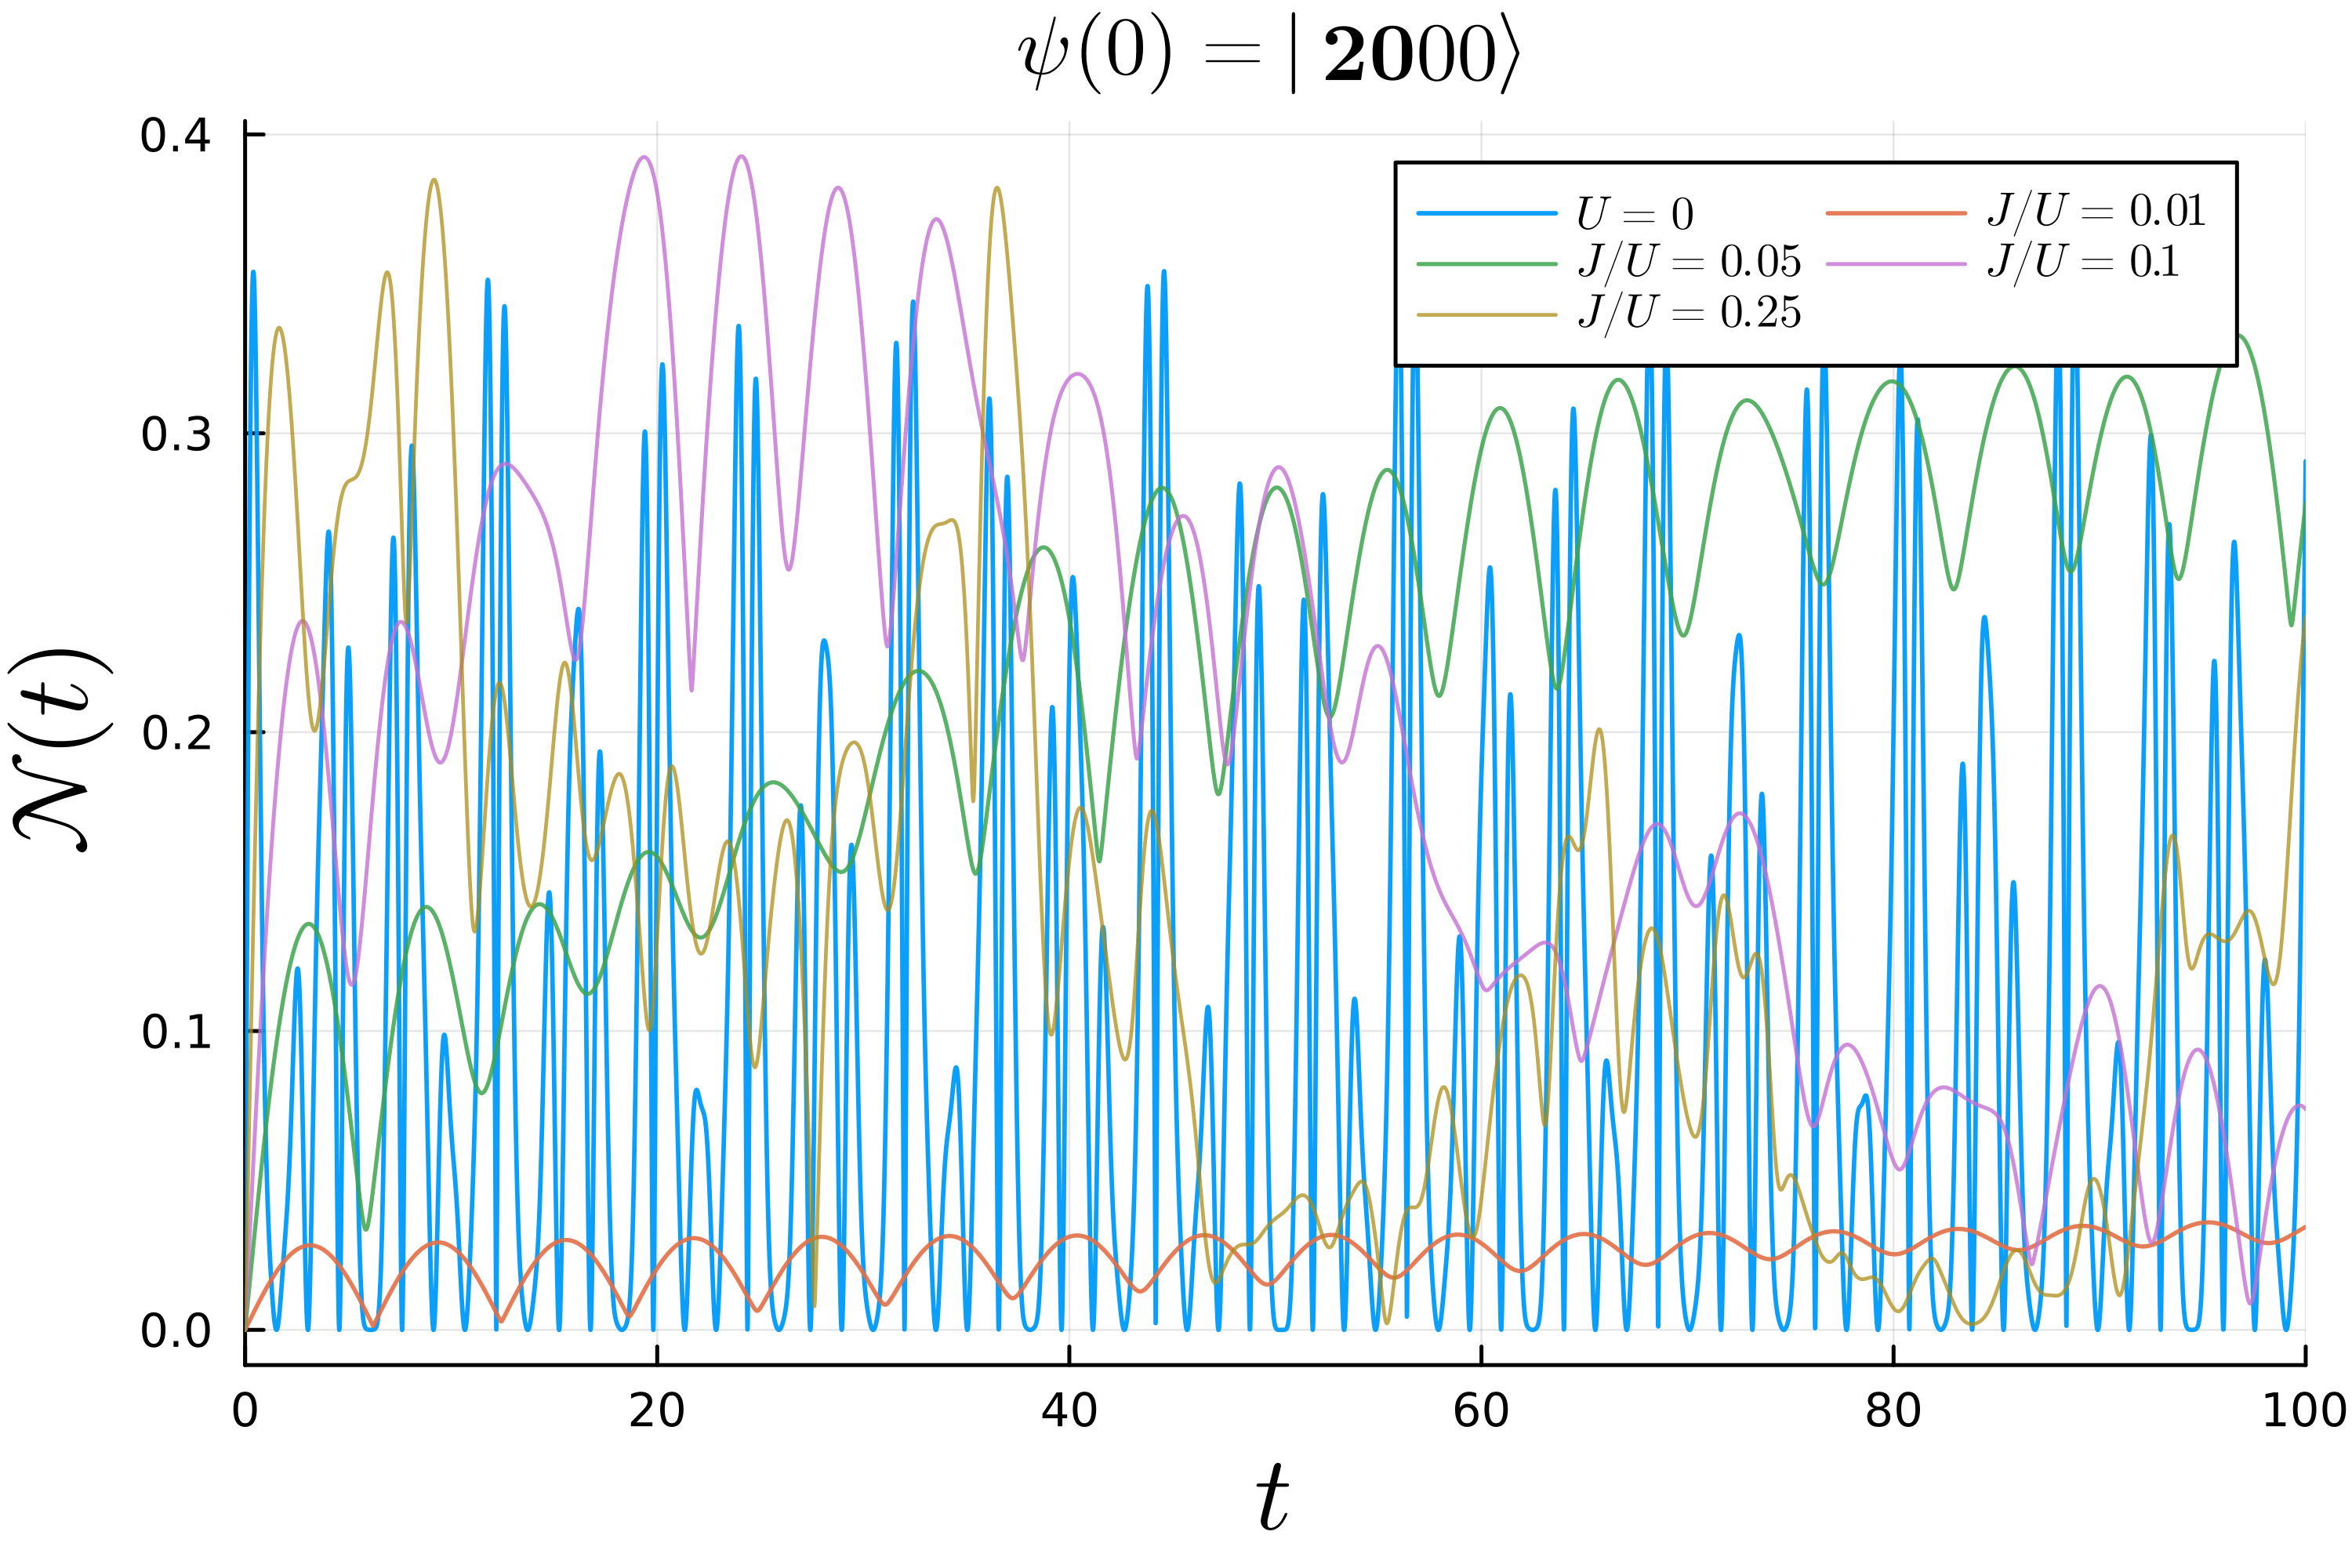

In [30]:
plot(uidefont=fnt,fmt = :png, dpi=500.,
    ylabel=L"\mathcal{N}(t)",xlabel=L"t",title=L"\psi(0)=|"*name2*L"\rangle",#title=L"N=%$N, M=%$M,  J/U=%$(J)",
    legend=:best, legendcolumns=2,legendfontsize=8,
    xlims=(0,100),
    guidefontsize=18)
for i=1:length(Js)
    labelp=L"J/U=%$(Js[i])"
    if i==1 && Js[i]==1.0
        labelp=L"U=0"
    end
    DATA_N=readdlm(direcciones[i])
    plot!(DATA_N[:,1],DATA_N[:,2],label=labelp,lw=1.2-(i*0.05)*(1),alpha=1-(i*0.05)^(1))
end
plot!()

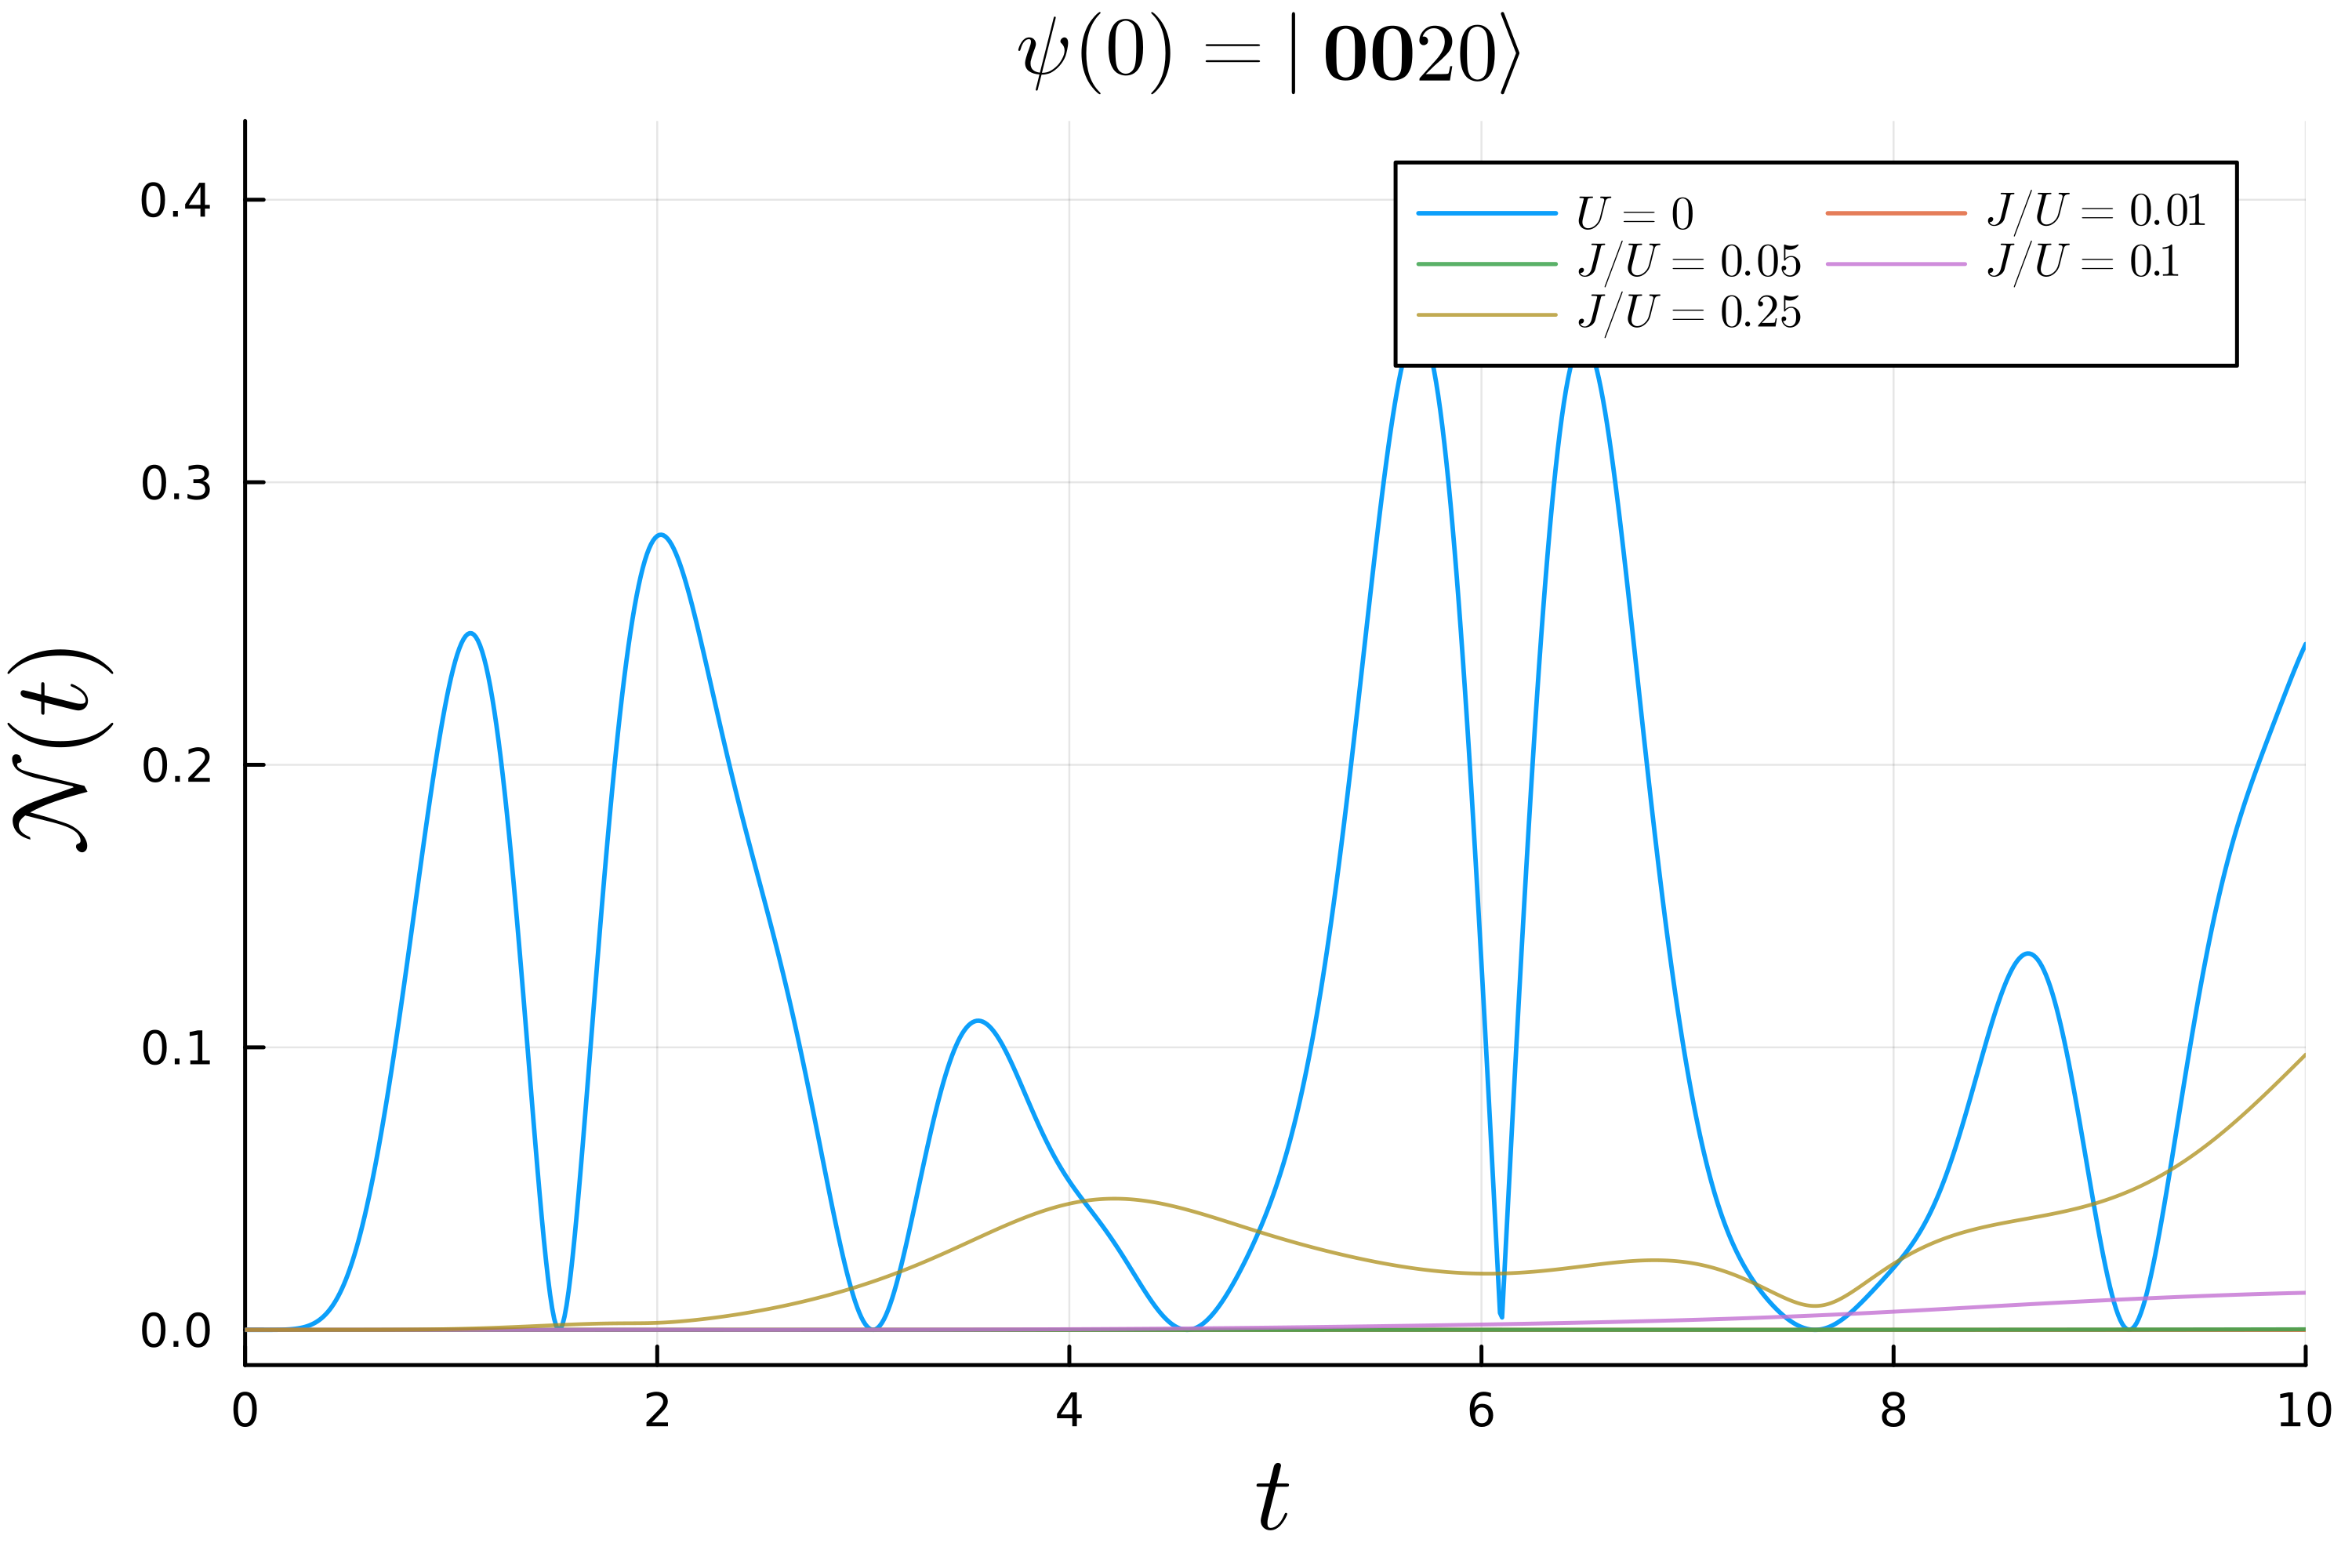

In [210]:
plot(uidefont=fnt,fmt = :png, dpi=500.,
    ylabel=L"\mathcal{N}(t)",xlabel=L"t",title=L"\psi(0)=|"*name2*L"\rangle",#title=L"N=%$N, M=%$M,  J/U=%$(J)",
    legend=:best, legendcolumns=2,legendfontsize=8,
    xlims=(0,10),
    guidefontsize=18)
for i=1:length(Js)
    labelp=L"J/U=%$(Js[i])"
    if i==1 && Js[i]==1.0
        labelp=L"U=0"
    end
    DATA_N=readdlm(direcciones[i])
    plot!(DATA_N[:,1],DATA_N[:,2],label=labelp,lw=1.2-(i*0.05)*(1),alpha=1-(i*0.05)^(1))
end
plot!()